In [1]:
import sys
sys.path.append("C:/Users/timlf/PycharmProjects/Semester_Project_Too/LIFE-Retrieval-Framework/pyretlife/retrieval_plotting/")

from run_plotting import retrieval_plotting_object



problem: Could not find module 'libmultinest.dll' (or one of its dependencies). Try using the full path with constructor syntax.


SystemExit: 1

C:\Users\timlf\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import os
print(os.environ.get("PATH"))

C:\Users\timlf\PycharmProjects\Semester_Project_Too\.venv\Scripts;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\ffmpeg-7.1-essentials_build\bin;C:\TDM-GCC-64\bin;C:\Program Files\Git\cmd;C:\Users\timlf\AppData\Local\Programs\Python\Launcher\;C:\Users\timlf\AppData\Local\Microsoft\WindowsApps;C:\Users\timlf\AppData\Roaming\Programs\Zero Install;C:\Users\timlf\AppData\Local\GitHubDesktop\bin;C:\msys64\mingw64\bin;


In [1]:
import sys, platform
print("Python executable:", sys.executable)
print("Platform:", platform.system())

Python executable: /home/timlf/myenv/bin/python
Platform: Linux


In [4]:
from pyretlife import *

In [1]:
import pyretlife
print(pyretlife.__file__)

/home/timlf/software/pyRetLIFE/pyretlife/__init__.py


In [2]:
from argparse import ArgumentParser, Namespace
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.ndimage import gaussian_filter

from pyretlife.retrieval_plotting.run_plotting import retrieval_plotting_object
from pyretlife.retrieval_plotting.posterior_plotting import (
    Generate_Parameter_Titles,
    Scale_Posteriors
)

In [9]:
def get_cli_arguments(arg_list: list[str] | None = None) -> Namespace:
    parser = ArgumentParser(description="Run nested sampling with configuration options.")

    parser.add_argument(
        "--config",
        required=True,
        type=str,
        help="Path to the configuration file."
    )

    parser.add_argument(
        "--nproc",
        required=True,
        type=int,
        help="Number of processes to use."
    )

    parser.add_argument(
        "--sampler",
        required=False,
        type=str,
        choices=["MultiNest", "Nautilus"],
        default="MultiNest",
        help="Nested sampling algorithm (default: MultiNest)."
    )

    return parser.parse_args(arg_list)


# Example: simulate command-line arguments directly in code
args = get_cli_arguments(["--config", "/mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/input_new.yaml", "--nproc", "4", "--sampler", "MultiNest"])

print(args)
print(args.config, args.nproc, args.sampler)

Namespace(config='/mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/input_new.yaml', nproc=4, sampler='MultiNest')
/mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/input_new.yaml 4 MultiNest


In [2]:
from pyretlife.retrieval_plotting.run_plotting import retrieval_plotting_object
# results = retrieval_plotting_object('/mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/')

In [4]:
results.calculate_posterior_pt_profile(n_processes=min([200,int(args.nproc)]),reevaluate_PT=False)

results.calculate_posterior_spectrum(n_processes=min([200,int(args.nproc)]),reevaluate_spectra=False)

results.deduce_bond_albedo(stellar_luminosity=1.0,
										error_stellar_luminosity=0.01,
                                        planet_star_separation=1.0,
                                        error_planet_star_separation=0.01,
                                        true_equilibrium_temperature = 255,
                                        true_bond_albedo = 0.29,
                                        reevaluate_bond_albedo=False)
results.deduce_abundance_profiles(reevaluate_abundance_profiles=False)

results.deduce_gravity(true_gravity = 981)
results.deduce_surface_temperature(true_surface_temperature = 273)

unit_titles = {'R_pl':'$\mathrm{R_{Earth}}$','M_pl':'$\mathrm{M_{Earth}}$'}

Loaded previously calculated PT profiles from /mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/Plots_New/Ret_PT_Skip_1.pkl.

Loaded previously calculated spectra from /mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/Plots_New/Ret_Spec_Skip_1.pkl.

Loaded previously calculated Bond albedos from /mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/Plots_New/Ret_Bond_Albedo.pkl.

Loaded previously calculated abundance profiles from /mnt/d/timlf/Tim Daten/Desktop/VH2O_CL_gauss10/Plots_New/Ret_Abundance_Profiles.pkl.



In [3]:
def load_data(
        self,
        log_pressures=True,
        log_mass=True,
        log_abundances=True,
        log_particle_radii=True,
        plot_pt=True,
        plot_physparam=True,
        plot_clouds=True,
        plot_chemcomp=True,
        plot_scatt=True,
        plot_moon=False,
        plot_secondary_parameters=True,
        parameter_units='input',
        custom_unit_titles={},
        custom_parameter_titles={}
):
    """
    Loads and returns the data for the retrieved parameters as well as the upper-log-uniform (ULU), the truth values and the parameter names.

    Parameters
    ----------
    log_pressures :  bool, optional
        If True, applies a logarithmic scale to pressure values. Defaults to True.

    log_mass : bool, optional
        If True, applies a logarithmic scale to mass values. Defaults to True.

    log_abundances :  bool, optional
        If True, applies a logarithmic scale to abundance values. Defaults to True.

    log_particle_radii : bool, optional
        If True, applies a logarithmic scale to particle radii values. Defaults to True.

    plot_pt :  bool, optional
        If True, plots pressure-temperature parameters. Defaults to True.

    plot_physparam : bool, optional
        If True, plots physical parameters. Defaults to True.

    plot_clouds :  bool, optional
        If True, plots cloud parameters. Defaults to True.

    plot_chemcomp : bool, optional
        If True, plots chemical composition parameters. Defaults to True.

    plot_scatt : bool, optional
        If True, plots scattering parameters. Defaults to True.

    plot_moon :  bool, optional
        If True, plots moon parameters. Defaults to False.

    plot_secondary_parameters : bool, optional
        If True, plots secondary parameters. Defaults to True.

    parameter_units : str, optional
        The units to use for plotting. Defaults to 'input', which are the units specified in the config file.

    custom_unit_titles : dict, optional
        A dictionary mapping parameters to custom unit titles. Defaults to an empty dictionary.

    custom_parameter_titles={} : dict, optional
        A dictionary mapping parameters to custom titles. Defaults to an empty dictionary.
    """

    self.calculate_posterior_pt_profile(n_processes=4,reevaluate_PT=False)

    self.calculate_posterior_spectrum(n_processes=4,reevaluate_spectra=False)

    self.deduce_bond_albedo(stellar_luminosity=1.0,
                            error_stellar_luminosity=0.01,
                            planet_star_separation=1.0,
                            error_planet_star_separation=0.01,
                            true_equilibrium_temperature = 255,
                            true_bond_albedo = 0.29,
                            reevaluate_bond_albedo=False)
    self.deduce_abundance_profiles(reevaluate_abundance_profiles=False)

    self.deduce_gravity(true_gravity = 981)
    self.deduce_surface_temperature(true_surface_temperature = 273)

    parameters_plotted = []
    for parameter in self.parameters:
        if (self.parameters[parameter]['type'] == 'TEMPERATURE PARAMETERS') and plot_pt:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'PHYSICAL PARAMETERS') and plot_physparam:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'CHEMICAL COMPOSITION PARAMETERS') and plot_chemcomp:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'CLOUD PARAMETERS') and plot_clouds:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'SCATTERING PARAMETERS') and plot_scatt:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'SECONDARY PARAMETERS') and plot_secondary_parameters:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'MOON PARAMETERS') and plot_moon:
            parameters_plotted += [parameter]

    local_post = self.posteriors.copy()
    local_truths = {parameter:self.parameters[parameter]['truth'] for parameter in parameters_plotted}

    Generate_Parameter_Titles(self)
    local_titles = {i:self.parameters[i]['title'] for i in parameters_plotted}
    for parameter in parameters_plotted:
        if parameter in custom_parameter_titles:
            local_titles[parameter] = custom_parameter_titles[parameter]

    retrieval_unit =  {i:self.parameters[i]['unit'] for i in parameters_plotted}
    if parameter_units == 'input':
        local_units = {i:self.parameters[i]['input_unit'] for i in parameters_plotted}
    else:
        local_units = retrieval_unit.copy()
        for parameter in parameters_plotted:
            if parameter in parameter_units:
                local_units[parameter] = parameter_units[parameter]

    for parameter in parameters_plotted:
        if not f"{local_units[parameter]:latex}" == '$\\mathrm{}$':
            unit = '\\left['+f"{local_units[parameter]:latex}"[1:-1]+'\\right]'
        else:
            unit = ''
        if parameter in custom_unit_titles:
            unit = '\\left['+custom_unit_titles[parameter][1:-1]+'\\right]'
        local_titles[parameter] = local_titles[parameter][:-1]+unit+'$'

    for parameter in parameters_plotted:
        local_post[parameter]   = self.units.truth_unit_conversion(parameter,retrieval_unit[parameter],local_units[parameter],local_post[parameter].to_numpy(),printing=False)
        local_truths[parameter] = self.units.truth_unit_conversion(parameter,retrieval_unit[parameter],local_units[parameter],local_truths[parameter],printing=False)

    local_post, local_truths, local_titles = Scale_Posteriors(self,local_post, local_truths, local_titles, parameters_plotted,
                                                              log_pressures=log_pressures, log_mass=log_mass,
                                                              log_abundances=log_abundances, log_particle_radii=log_particle_radii)

    ULU = [parameter for parameter in parameters_plotted if self.parameters[parameter]['prior']['kind'] == 'upper-log-uniform']

    dataset = {}
    for param in parameters_plotted:
        dataset[param] = local_post[param]

    return dataset, ULU, local_truths, parameters_plotted

In [4]:
retrieval_plotting_object.load_data = load_data

def plot_retrievals(
        labels,
        folders,
        colors=None,
        params_to_plot=None,
        bins=50,
        fig_title=None,
        output='retrieval_comparison.pdf',
        ULU_lim=[-0.15,0.75],
):
    """
    Plot the histogram for a series of retrievals.

    Parameters
    ----------
    labels : dict
        Dictionary mapping run names to legend labels.

    folders : dict
        Dictionary mapping run names to folder with the run data.

    colors : dict, optional
        Dictionary mapping run names to histogram colors. Default is a generic color palette with 10 unique options.

    params_to_plot : list, optional
        List of parameter names to plot. Default is all.

    bins : int or sequence, optional
        Number of histogram bins (default 50).

    fig_title : str, optional
        Title for the whole figure.

    ULUs : list, optional
        List of parameter names for which specific upper limit uncertainty correction should be applied. Default is None.

    ULU_lim : list, optional
        Limits for the ULU correction (lower bound and smoothing factor). Default is [-0.15, 0.75].
    """

    datasets = {}
    ULUs = {}
    local_truths = []
    params = []
    for label in labels.keys():
        results = retrieval_plotting_object(folders[label], run_retrieval=True)
        datasets[label], ULUs[label], local_truths, params = results.load_data()

    n_params = len(params)
    n_cols = 4
    n_rows = int(np.ceil(n_params / n_cols))

    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(4.5 * n_cols, 3 * n_rows),
        constrained_layout=False
    )
    axs = axs.flatten()

    if colors is None:
        default_colors = [
            "gray", "mediumpurple", "indianred", "goldenrod", "steelblue", "darkorange", "seagreen", "firebrick", "royalblue", "darkkhaki"
        ]
        colors = {label: default_colors[i % len(default_colors)] for i, label in enumerate(datasets.keys())}

    for i, param in enumerate(params):
        if params_to_plot is not None and param not in params_to_plot:
            continue

        ax = axs[i]

        for run_name, data in datasets.items():
            if ULUs is not None and param in ULUs[run_name]:
                h = np.histogram(data[param],density=True,bins=bins,range = (ULU_lim[0],0))
                h2 = np.histogram(np.log10(1-10**(np.arange(-7,0,0.000001))),density=True,bins=h[1])
                h = (h[0]/h2[0],h[1])
                h = ax.hist(
                    h[1][: -1],
                    h[1],
                    weights = sp.ndimage.filters.gaussian_filter(h[0], [ULU_lim[1]], mode='constant'),
                    histtype='stepfilled',
                    color=colors.get(run_name, 'gray'),
                    density=True,
                    label=labels.get(run_name, run_name)
                )
            else:
                if param in data.keys():
                    h = ax.hist(
                        data[param],
                        histtype='stepfilled',
                        color=colors.get(run_name, 'gray'),
                        alpha=0.6,
                        density=True,
                        bins=bins,
                        label=labels.get(run_name, run_name)
                    )

        ax.set_title(param, fontsize=12)
        ax.set_ylabel("Prob. density")
        ax.tick_params(labelsize=10)
        ax.grid(False)

        ax.axvline(local_truths[param], color='k', linestyle='--', linewidth=1.5)

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    fig.subplots_adjust(top=0.90, bottom=0.08, left=0.07, right=0.98, hspace=0.35, wspace=0.25)

    if fig_title:
        fig.suptitle(fig_title, fontsize=16, weight='bold', y=0.965)

    # Create a single legend above all plots
    handles, legend_labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles,
        legend_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.935),
        ncol=len(datasets),
        fontsize=11,
        frameon=False
    )
    plt.savefig(output)
    plt.show()

Conversion performed for truth value of d_syst.
Input value: 10.0 pRT_pc
Converted value: 3.085677581491368e+17 m

Conversion performed for truth value of M_pl.
Input value: 1.0 pRT_M_earth
Converted value: 5.972167867791379e+27 g

Conversion performed for truth value of R_pl.
Input value: 1.0 pRT_R_earth
Converted value: 637810000.0 cm

Conversion performed for prior of R_pl. Prior kind: gaussian
Input values: {'mean': 1, 'sigma': 0.2} pRT_R_earth
Converted value: {'mean': 637810000.0, 'sigma': 127562000.0} cm

Nautilus output not found, trying MultiNest...
  analysing data from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/.txt
Loaded previously calculated PT profiles from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/Plots_New/Ret_PT_Skip_1.pkl.

Loaded previously calculated spectra from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/Plots_New/Ret_Spec_Skip_1.pkl.

Loaded previously calculated Bond albedos from /mnt/d/timlf/Tim Da

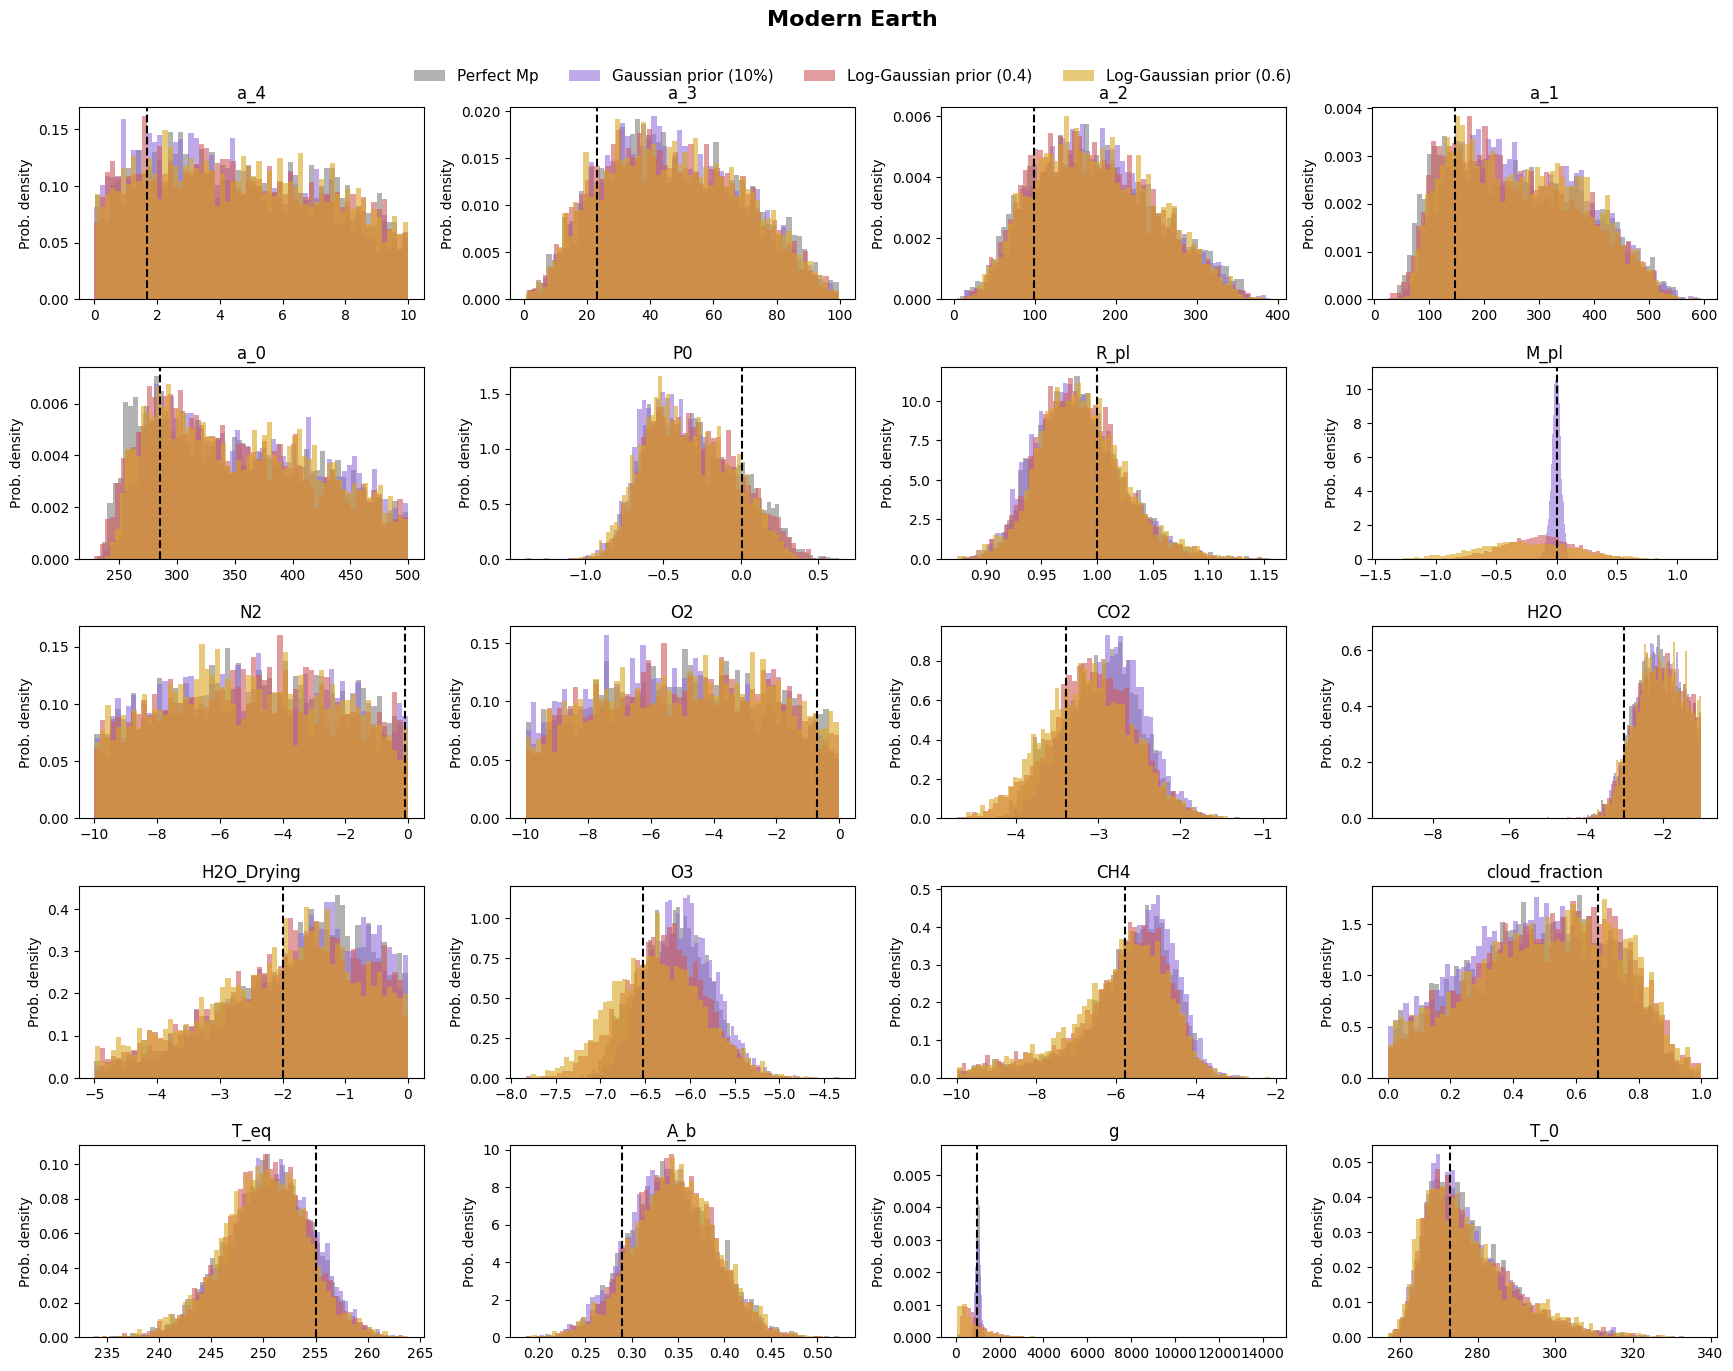

In [6]:
labels = {
    "Perfect Mp": "Perfect Mp",
    # "Unknown Mp": "Unknown Mp",
    "Gaussian 10": "Gaussian prior (10%)",
    "Loggauss 4": "Log-Gaussian prior (0.4)",
    "Loggauss 6": "Log-Gaussian prior (0.6)",
}

colors = {
    "Perfect Mp": "gray",
    # "Unknown Mp": "purple",
    "Gaussian 10": "goldenrod",
}

folders = {
    "Perfect Mp": '/mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/',
    # "Unknown Mp": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/Retrieval2_uniform/',
    "Gaussian 10": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_gauss10/',
    "Loggauss 4": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_log04/',
    "Loggauss 6": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_log06/',
}

plot_retrievals(labels, folders, bins=60, fig_title="Modern Earth")

In [24]:
import pickle
load_file = open('/mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/Plots_New/Ret_Abundance_Profiles.pkl', "rb")
results = pickle.load(load_file)
load_file.close()

In [25]:
results

{'pressures': array([[1.00000000e-04, 1.08139532e-04, 1.16941584e-04, ...,
         1.97922516e-01, 2.14032483e-01, 2.31453726e-01],
        [1.00000000e-04, 1.08361868e-04, 1.17422944e-04, ...,
         2.41556563e-01, 2.61755204e-01, 2.83642829e-01],
        [1.00000000e-04, 1.08122114e-04, 1.16903915e-04, ...,
         1.94853957e-01, 2.10680217e-01, 2.27791905e-01],
        ...,
        [1.00000000e-04, 1.10456074e-04, 1.22005443e-04, ...,
         1.54664832e+00, 1.70836701e+00, 1.88699514e+00],
        [1.00000000e-04, 1.10116824e-04, 1.21257150e-04, ...,
         1.14764289e+00, 1.26374790e+00, 1.39159906e+00],
        [1.00000000e-04, 1.10552841e-04, 1.22219307e-04, ...,
         1.68376342e+00, 1.86144830e+00, 2.05788398e+00]]),
 'N2_VMR': array([[3.90915639e-02, 3.90915639e-02, 3.90915639e-02, ...,
         3.90915639e-02, 3.90915639e-02, 3.90915639e-02],
        [2.77383607e-05, 2.77383607e-05, 2.77383607e-05, ...,
         2.77383607e-05, 2.77383607e-05, 2.77383607e-05],
  

In [26]:
print(len(results['N2_VMR']))

4117


In [4]:
result = retrieval_plotting_object(results_directory='/mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/', run_retrieval=True)

Conversion performed for truth value of d_syst.
Input value: 10.0 pRT_pc
Converted value: 3.085677581491368e+17 m

Conversion performed for truth value of M_pl.
Input value: 1.0 pRT_M_earth
Converted value: 5.972167867791379e+27 g

Conversion performed for truth value of R_pl.
Input value: 1.0 pRT_R_earth
Converted value: 637810000.0 cm

Conversion performed for prior of R_pl. Prior kind: gaussian
Input values: {'mean': 1, 'sigma': 0.2} pRT_R_earth
Converted value: {'mean': 637810000.0, 'sigma': 127562000.0} cm

Nautilus output not found, trying MultiNest...
  analysing data from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/.txt


In [27]:
result.calculate_posterior_spectrum(reevaluate_spectra=False)

Loaded previously calculated spectra from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/Plots_New/Ret_Spec_Skip_1.pkl.



In [31]:
np.shape(result.retrieved_fluxes)

(4158, 169)

In [32]:
result.calculate_true_spectrum()

In [30]:
result.true_fluxes

array([[2.66140552e-29, 2.83528496e-29, 3.29458503e-29, 3.78538509e-29,
        4.26833638e-29, 4.83840399e-29, 5.40048282e-29, 6.05936358e-29,
        6.71908224e-29, 7.41739611e-29, 8.22125224e-29, 8.97935650e-29,
        9.74273687e-29, 1.03619351e-28, 1.07045514e-28, 1.07643665e-28,
        1.08811259e-28, 9.36260424e-29, 2.65464973e-29, 4.32911295e-29,
        4.57884858e-29, 3.12976875e-29, 7.58752249e-29, 2.07780796e-28,
        2.61096289e-28, 3.00555712e-28, 3.43637681e-28, 3.86038308e-28,
        4.21418420e-28, 4.17975682e-28, 4.46329219e-28, 4.39563455e-28,
        4.40657929e-28, 5.41603338e-28, 5.98563205e-28, 6.74311432e-28,
        6.55995201e-28, 7.01078120e-28, 6.43303180e-28, 6.75797838e-28,
        6.83610735e-28, 6.98313737e-28, 7.14590185e-28, 7.28740337e-28,
        6.41148504e-28, 8.04282390e-28, 6.58472079e-28, 6.97189342e-28,
        7.64531185e-28, 7.00309005e-28, 8.22515510e-28, 7.90392709e-28,
        8.10323548e-28, 9.00331421e-28, 9.87610864e-28, 1.020450

In [12]:
import pymultinest as nest
data = nest.Analyzer(len(result.parameters.keys()),outputfiles_basename = result.results_directory)
posterior_parameter_names = list(result.parameters.keys())+['likelihood']

  analysing data from /mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/Retrieval2_uniform/.txt


In [13]:
print(data.get_equal_weighted_posterior().shape)

(4199, 17)


In [6]:
result.calculate_posterior_pt_profile(n_processes=4,reevaluate_PT=True)
# result.calculate_posterior_spectrum(n_processes=4,reevaluate_spectra=False)

# result.deduce_bond_albedo(stellar_luminosity=1.0,
#                             error_stellar_luminosity=0.01,
#                             planet_star_separation=1.0,
#                             error_planet_star_separation=0.01,
#                             true_equilibrium_temperature = 255,
#                             true_bond_albedo = 0.29,
#                             reevaluate_bond_albedo=True)

# result.deduce_surface_temperature(true_surface_temperature = 273)

Calculating retrieved PT profiles from scratch.

-----------------------------------------------------

    PT-Profile calculation on multiple CPUs:

    Number of calculations:	4158
    Number of processes:	4

    Distribution of tasks:
	Process 0:	PT-Profile:	1-1039
	Process 1:	PT-Profile:	1040-2079
	Process 2:	PT-Profile:	2080-3118
	Process 3:	PT-Profile:	3119-4158

-----------------------------------------------------

Starting PT-profile calculation.
	100.0 % of PT-profiles calculated. Estimated time remaining: 0.0 h, 0.0 min.        
PT-profile calculation completed.
Combining all data.
Done combining all data.
Saved calculated PT profiles in /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/Plots_New/Ret_PT_Skip_1.pkl.



In [7]:
result.retrieved_temperatures

array([[254.04773683, 256.47078778, 258.81932594, ..., 297.7897317 ,
        308.12278365, 319.12264534],
       [178.92246927, 182.23488855, 185.40039209, ..., 272.69992484,
        276.3803825 , 280.22692919],
       [348.13094507, 339.61575764, 331.557832  , ..., 256.05188264,
        259.8693244 , 263.97834766],
       ...,
       [327.22250183, 320.07974027, 313.38751556, ..., 279.74776184,
        286.90209588, 294.58011142],
       [204.55770745, 205.56218447, 206.67807266, ..., 255.37430362,
        260.93354574, 266.95732068],
       [292.50807413, 290.14466844, 287.91750226, ..., 285.73791986,
        292.59102472, 299.87235811]])